In [51]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import random
import shutil
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import Counter

In [52]:
base_dir = "/media/sid/Sid-HDD/Datasets/Vision/Sideguide/Polygon(surface)/Extracted"
output_dir = "/media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg"
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

data_fraction = 0.20

os.makedirs(output_dir, exist_ok=True)

In [53]:
def convert_polygon_to_yolo(points_str, width, height):
    points = []
    for point_pair in points_str.split(';'):
        if point_pair:
            x, y = map(float, point_pair.split(','))
            # Normalize coordinates
            x_norm = x / width
            y_norm = y / height
            points.extend([x_norm, y_norm])
    
    return points

def create_output_dirs():
    """Create the required directory structure for YOLO segmentation"""
    os.makedirs(os.path.join(output_dir, "train", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "train", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "valid", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "valid", "labels"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "images"), exist_ok=True)
    os.makedirs(os.path.join(output_dir, "test", "labels"), exist_ok=True)

In [54]:
def find_all_files():
    xml_files = []
    image_files = []
    
    for surface_folder in tqdm(os.listdir(base_dir), desc="Scanning main folders"):
        surface_path = os.path.join(base_dir, surface_folder)
        if not os.path.isdir(surface_path):
            continue
        
        for subfolder in tqdm(os.listdir(surface_path), 
                             desc=f"Scanning {surface_folder}", leave=False):
            subfolder_path = os.path.join(surface_path, subfolder)
            if not os.path.isdir(subfolder_path):
                continue
            
            for file in os.listdir(subfolder_path):
                if file.endswith(".xml"):
                    xml_files.append(os.path.join(subfolder_path, file))
            
            for file in os.listdir(subfolder_path):
                if file.endswith((".jpg", ".jpeg", ".png")) and not file.startswith("._"):
                    image_files.append(os.path.join(subfolder_path, file))
    
    print(f"Found {len(xml_files)} XML files and {len(image_files)} images")
    return xml_files, image_files

xml_files, image_files = find_all_files()

if data_fraction < 1.0:
    random.shuffle(xml_files)
    xml_files = xml_files[:int(len(xml_files) * data_fraction)]
    print(f"Using {len(xml_files)} XML files ({data_fraction*100:.1f}% of total)")

Scanning main folders:   0%|          | 0/5 [00:00<?, ?it/s]

Scanning Surface_1:   0%|          | 0/130 [00:00<?, ?it/s]

Scanning Surface_2:   0%|          | 0/170 [00:00<?, ?it/s]

Scanning Surface_3:   0%|          | 0/170 [00:00<?, ?it/s]

Scanning Surface_4:   0%|          | 0/160 [00:00<?, ?it/s]

Scanning Surface_5:   0%|          | 0/170 [00:00<?, ?it/s]

Found 800 XML files and 46399 images
Using 160 XML files (20.0% of total)


In [55]:
def process_cvat_xml(xml_files, image_files):
    all_classes = set()
    dataset = []
    
    image_lookup = {}
    for img_path in image_files:
        img_name = os.path.basename(img_path)
        image_lookup[img_name] = img_path
    
    for xml_file in tqdm(xml_files, desc="Processing XML files"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            
            labels_section = root.find('.//task/labels')
            if labels_section:
                for label in labels_section.findall('.//label/name'):
                    all_classes.add(label.text)

            for image in root.findall('.//image'):
                img_name = image.get('name')
                width = int(image.get('width', 1920))  
                height = int(image.get('height', 1080)) 
                
                img_path = image_lookup.get(img_name)
                if not img_path:
                    continue
                
                polygons = []
                for polygon in image.findall('polygon'):
                    label = polygon.get('label')
                    points = polygon.get('points')
                    
                    if label and points:
                        all_classes.add(label)
                        polygons.append({
                            'class': label,
                            'points': points
                        })
                
                if polygons:
                    dataset.append({
                        'xml_file': xml_file,
                        'img_file': img_path,
                        'width': width,
                        'height': height,
                        'polygons': polygons
                    })
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
    
    return list(all_classes), dataset

classes, dataset = process_cvat_xml(xml_files, image_files)

classes = sorted(classes)
print(f"Found {len(classes)} unique classes: {classes}")
print(f"Successfully processed {len(dataset)} images with polygon annotations")

Processing XML files:   0%|          | 0/160 [00:00<?, ?it/s]

Found 6 unique classes: ['alley', 'bike_lane', 'braille_guide_blocks', 'caution_zone', 'roadway', 'sidewalk']
Successfully processed 9429 images with polygon annotations


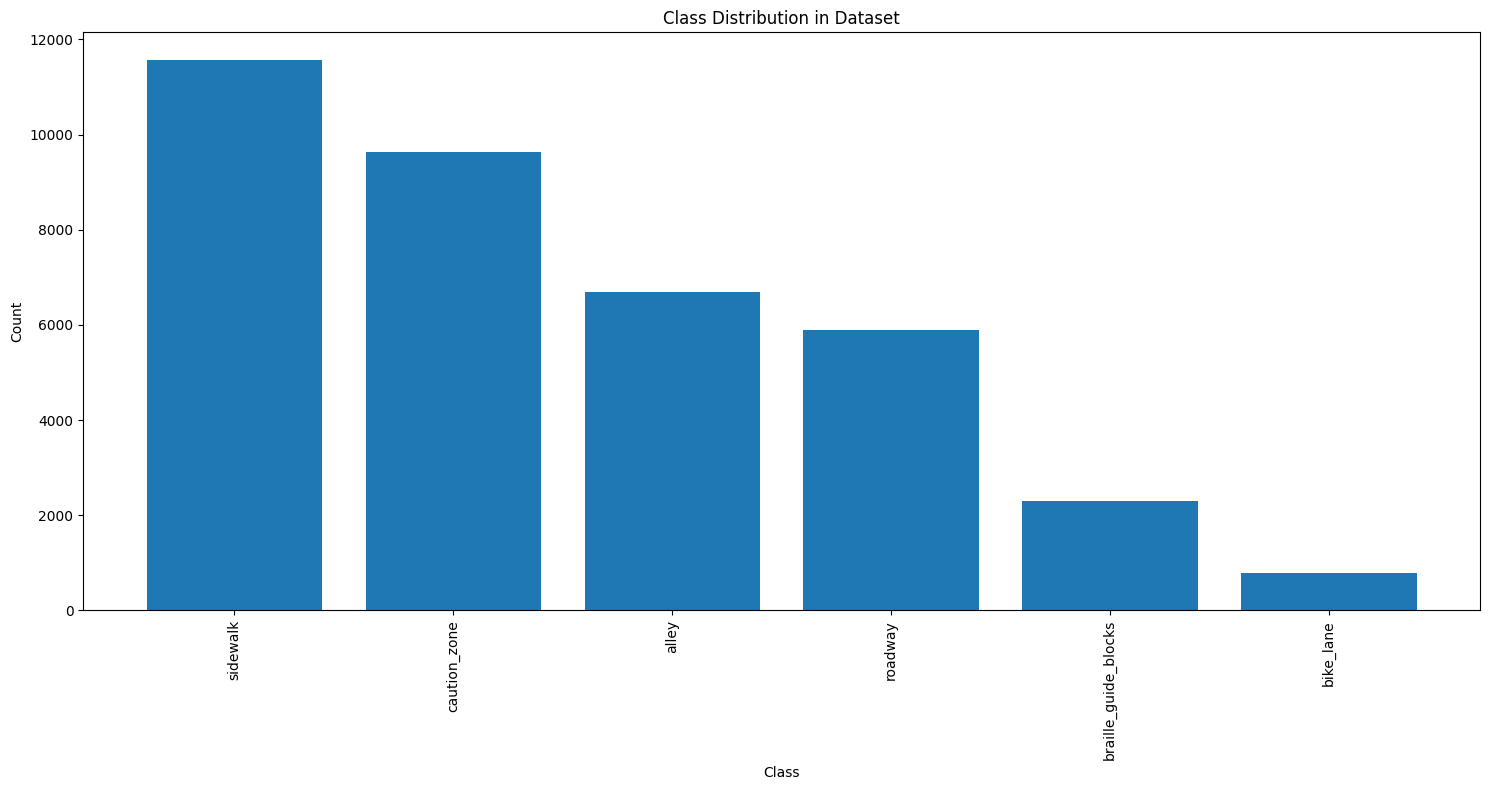

Class distribution:
sidewalk: 11571 (31.40%)
caution_zone: 9625 (26.12%)
alley: 6686 (18.14%)
roadway: 5895 (16.00%)
braille_guide_blocks: 2292 (6.22%)
bike_lane: 779 (2.11%)


In [56]:
class_counts = {}
for item in dataset:
    for polygon in item['polygons']:
        class_name = polygon['class']
        if class_name not in class_counts:
            class_counts[class_name] = 0
        class_counts[class_name] += 1

sorted_counts = sorted(class_counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(15, 8))
plt.bar([x[0] for x in sorted_counts], [x[1] for x in sorted_counts])
plt.xticks(rotation=90)
plt.title('Class Distribution in Dataset')
plt.xlabel('Class')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

print("Class distribution:")
total = sum(class_counts.values())
for cls, count in sorted_counts:
    print(f"{cls}: {count} ({count/total*100:.2f}%)")

In [57]:
def stratified_split(dataset, classes, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    class_files = {cls: [] for cls in classes}
    
    for i, item in enumerate(dataset):
        item_classes = set(polygon['class'] for polygon in item['polygons'])
        for cls in item_classes:
            class_files[cls].append(i)
    
    train_indices = set()
    val_indices = set()
    test_indices = set()
    
    for cls, indices in class_files.items():
        random.shuffle(indices)
        
        n_samples = len(indices)
        n_train = int(n_samples * train_ratio)
        n_val = int(n_samples * val_ratio)
        
        cls_train = indices[:n_train]
        cls_val = indices[n_train:n_train + n_val]
        cls_test = indices[n_train + n_val:]
        
        train_indices.update(cls_train)
        val_indices.update(cls_val)
        test_indices.update(cls_test)
    
    val_indices = val_indices - train_indices
    test_indices = test_indices - train_indices - val_indices
    
    train_data = [dataset[i] for i in train_indices]
    val_data = [dataset[i] for i in val_indices]
    test_data = [dataset[i] for i in test_indices]
    
    return train_data, val_data, test_data

train_data, val_data, test_data = stratified_split(dataset, classes, train_ratio, val_ratio, test_ratio)

print(f"Split dataset into:")
print(f"- Training: {len(train_data)} items ({len(train_data)/len(dataset)*100:.1f}%)")
print(f"- Validation: {len(val_data)} items ({len(val_data)/len(dataset)*100:.1f}%)")
print(f"- Testing: {len(test_data)} items ({len(test_data)/len(dataset)*100:.1f}%)")

Split dataset into:
- Training: 8430 items (89.4%)
- Validation: 590 items (6.3%)
- Testing: 409 items (4.3%)


In [58]:
create_output_dirs()

class_mapping = {cls: idx for idx, cls in enumerate(classes)}

print(f"Created directory structure for YOLO training")
print(f"Class mapping: {class_mapping}")

Created directory structure for YOLO training
Class mapping: {'alley': 0, 'bike_lane': 1, 'braille_guide_blocks': 2, 'caution_zone': 3, 'roadway': 4, 'sidewalk': 5}


In [59]:
def convert_to_yolo_format(item, output_dir, split_type, class_mapping):
    img_file = item['img_file']
    width = item['width']
    height = item['height']
    polygons = item['polygons']
    
    img_basename = os.path.basename(img_file)
    img_name_no_ext = os.path.splitext(img_basename)[0]
    
    output_img_dir = os.path.join(output_dir, split_type, "images")
    output_label_dir = os.path.join(output_dir, split_type, "labels")
    
    output_img_path = os.path.join(output_img_dir, img_basename)
    output_label_path = os.path.join(output_label_dir, f"{img_name_no_ext}.txt")
    
    if os.path.exists(output_label_path):
        return True

    try:
        shutil.copy2(img_file, output_img_path)
    except Exception as e:
        print(f"Error copying image {img_file}: {e}")
        return False
    
    try:
        with open(output_label_path, 'w') as f:
            for polygon in polygons:
                cls = polygon['class']
                if cls not in class_mapping:
                    continue
                
                cls_id = class_mapping[cls]
                points = polygon['points']
                
                yolo_coords = convert_polygon_to_yolo(points, width, height)
                
                if len(yolo_coords) < 6:
                    continue
                
                f.write(f"{cls_id} " + " ".join(map(str, yolo_coords)) + "\n")
        return True
    except Exception as e:
        print(f"Error creating label for {img_file}: {e}")
        return False

print("Converting training data...")
train_success = 0
for item in tqdm(train_data, desc="Processing training data"):
    if convert_to_yolo_format(item, output_dir, "train", class_mapping):
        train_success += 1

print("Converting validation data...")
val_success = 0
for item in tqdm(val_data, desc="Processing validation data"):
    if convert_to_yolo_format(item, output_dir, "valid", class_mapping):
        val_success += 1

print("Converting test data...")
test_success = 0
for item in tqdm(test_data, desc="Processing test data"):
    if convert_to_yolo_format(item, output_dir, "test", class_mapping):
        test_success += 1

print(f"Successfully converted:")
print(f"- Training: {train_success}/{len(train_data)} items")
print(f"- Validation: {val_success}/{len(val_data)} items")
print(f"- Testing: {test_success}/{len(test_data)} items")

Converting training data...


Processing training data:   0%|          | 0/8430 [00:00<?, ?it/s]

Converting validation data...


Processing validation data:   0%|          | 0/590 [00:00<?, ?it/s]

Converting test data...


Processing test data:   0%|          | 0/409 [00:00<?, ?it/s]

Successfully converted:
- Training: 8430/8430 items
- Validation: 590/590 items
- Testing: 409/409 items


In [60]:
# data.yaml
with open(os.path.join(output_dir, 'data.yaml'), 'w') as f:
    f.write(f"train: ./train/images\n")
    f.write(f"val: ./valid/images\n")
    f.write(f"test: ./test/images\n\n")
    f.write(f"nc: {len(classes)}\n")
    f.write(f"names: {str(classes)}\n")

print(f"Dataset prepared in {output_dir}")
print(f"Created data.yaml with {len(classes)} classes")

Dataset prepared in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg
Created data.yaml with 6 classes


Found 20843 images in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/images
Visualizing /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/images/MP_SEL_SUR_039401.jpg with labels from /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/labels/MP_SEL_SUR_039401.txt
Processing 3 polygons in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/labels/MP_SEL_SUR_039401.txt
Successfully drew 3 polygons


/tmp/ipykernel_47800/1308284065.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(class_names)).colors * 255


Visualizing /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/images/MP_SEL_SUR_026142.jpg with labels from /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/labels/MP_SEL_SUR_026142.txt
Processing 4 polygons in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/train/labels/MP_SEL_SUR_026142.txt
Successfully drew 4 polygons
Found 3087 images in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/valid/images
Visualizing /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/valid/images/MP_SEL_SUR_008446.jpg with labels from /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/valid/labels/MP_SEL_SUR_008446.txt
Processing 9 polygons in /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/valid/labels/MP_SEL_SUR_008446.txt
Successfully drew 9 polygons
Visualizing /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO_Seg/valid/images/MP_SEL_SUR_004799.jpg with labels from /media/sid/Sid-HDD/Datasets/Vision/Sideguide/YOLO/YOLO

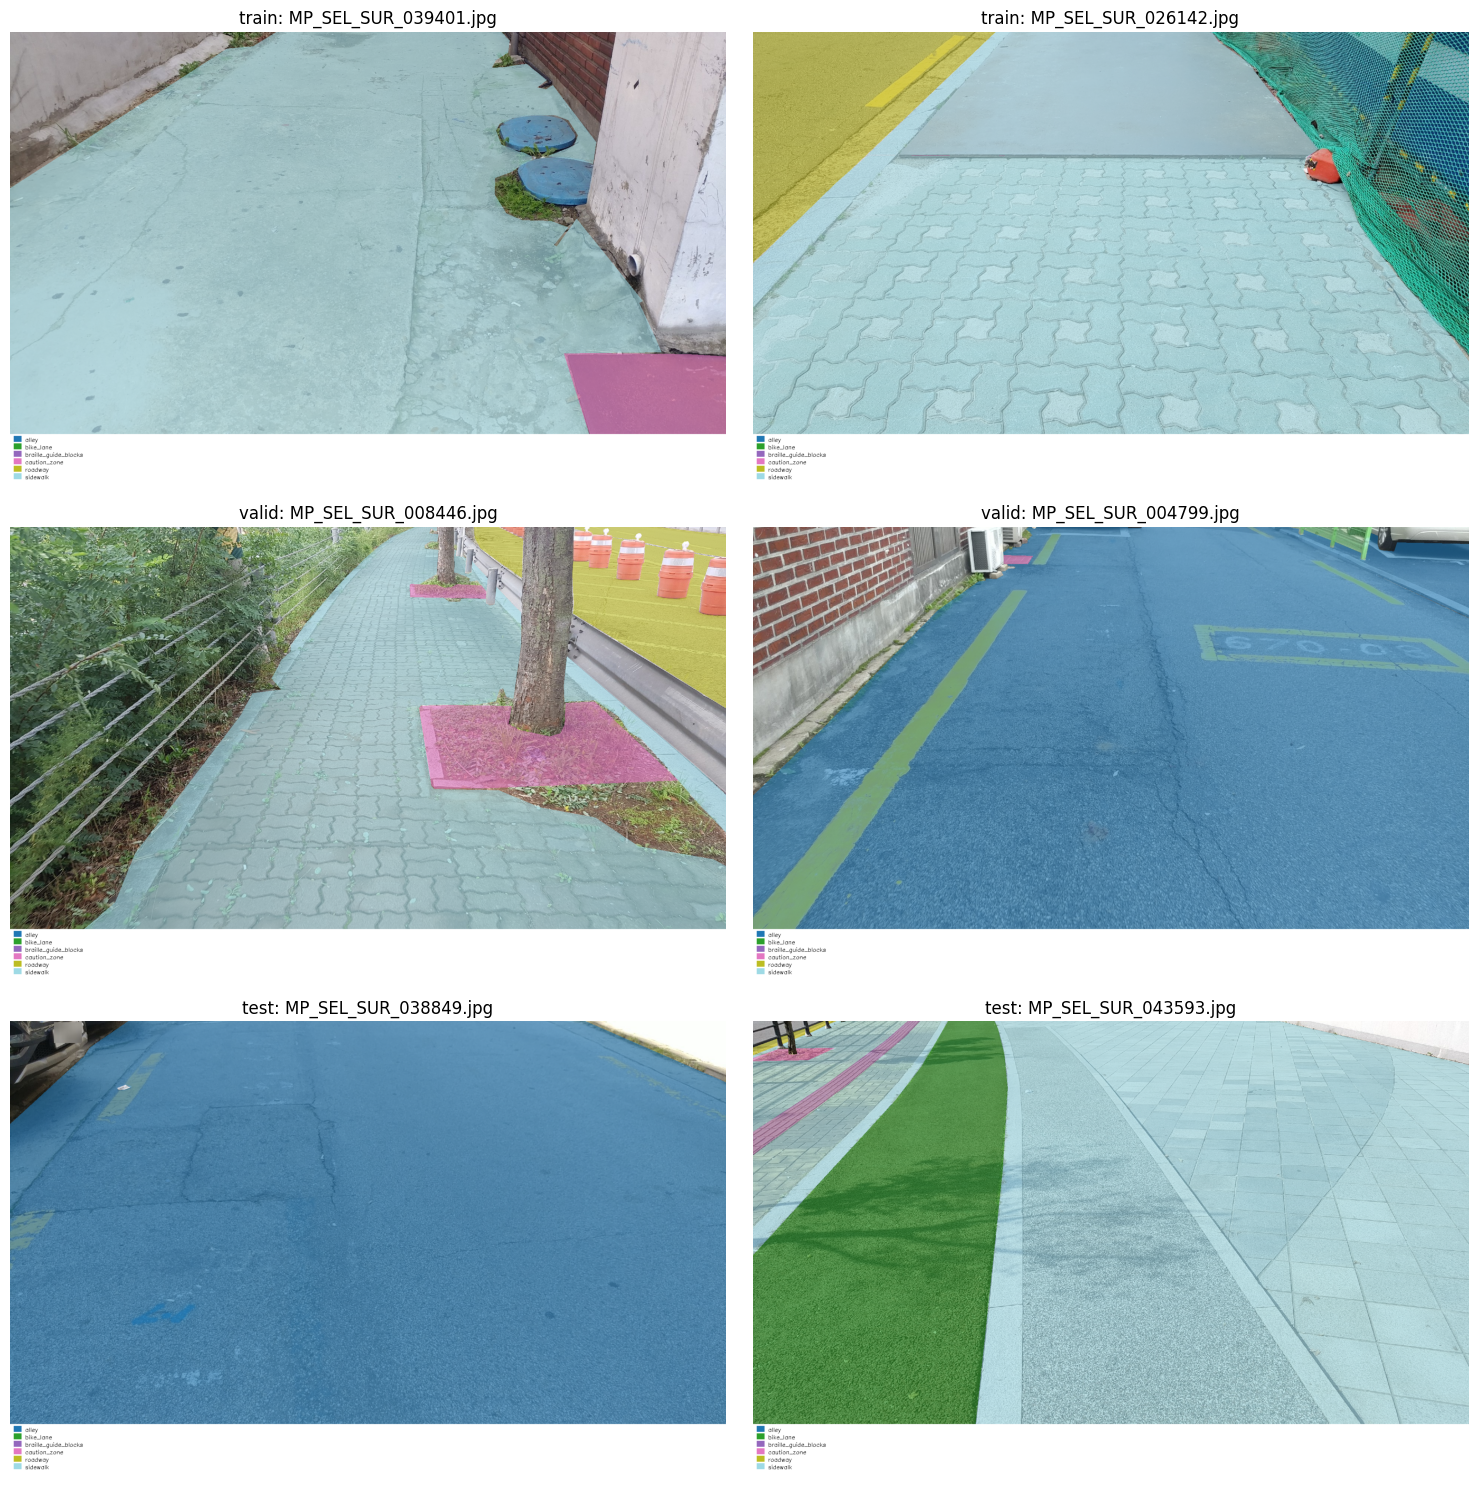

In [61]:
def visualize_yolo_segmentation(img_path, label_path, class_names):
    if not os.path.exists(img_path) or not os.path.exists(label_path):
        print(f"Image or label file not found: {img_path}, {label_path}")
        return

    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not read image: {img_path}")
        return
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, _ = img.shape

    vis_img = img.copy()

    colors = plt.cm.get_cmap('tab20', len(class_names)).colors * 255
    with open(label_path, 'r') as f:
        lines = f.readlines()
    
    print(f"Processing {len(lines)} polygons in {label_path}")
    
    polygon_count = 0
    for line in lines:
        parts = line.strip().split()
        if len(parts) < 7:
            print(f"Skipping line with insufficient points: {line.strip()}")
            continue
            
        cls_id = int(parts[0])
        polygon_points = list(map(float, parts[1:]))
        
        points = []
        for i in range(0, len(polygon_points), 2):
            if i+1 < len(polygon_points):
                x = int(polygon_points[i] * width)
                y = int(polygon_points[i+1] * height)
                points.append([x, y])
        
        if len(points) < 3:
            print(f"Skipping polygon with fewer than 3 points")
            continue
            
        points = np.array(points, dtype=np.int32)

        color = tuple(map(int, colors[cls_id % len(colors)]))
        cv2.fillPoly(vis_img, [points], color)
        polygon_count += 1
    
    print(f"Successfully drew {polygon_count} polygons")
    
    alpha = 0.6
    blended = cv2.addWeighted(vis_img, alpha, img, 1-alpha, 0)
    
    # Add legend
    legend_height = min(30 + len(class_names) * 20, 200)
    legend_img = np.ones((legend_height, width, 3), dtype=np.uint8) * 255
    y_offset = 20
    for i, cls_name in enumerate(class_names):
        if i >= len(colors):
            break
        color = tuple(map(int, colors[i % len(colors)]))
        cv2.rectangle(legend_img, (10, y_offset-15), (30, y_offset), color, -1)
        cv2.putText(legend_img, cls_name, (40, y_offset), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,0), 1)
        y_offset += 20
        if y_offset > legend_height - 10:
            break
    
    result = np.vstack([blended, legend_img])
    
    return result

def visualize_random_samples(output_dir, class_names, num_samples=2):
    splits = ["train", "valid", "test"]
    
    plt.figure(figsize=(15, 5*len(splits)))
    
    for i, split in enumerate(splits):
        img_dir = os.path.join(output_dir, split, "images")
        label_dir = os.path.join(output_dir, split, "labels")
        
        if not os.path.exists(img_dir):
            print(f"Directory not found: {img_dir}")
            continue
            
        if len(os.listdir(img_dir)) == 0:
            print(f"No images in {img_dir}")
            continue
            
        img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
        if len(img_files) == 0:
            print(f"No image files found in {img_dir}")
            continue
        
        print(f"Found {len(img_files)} images in {img_dir}")
            
        samples = random.sample(img_files, min(num_samples, len(img_files)))
        
        for j, img_file in enumerate(samples):
            img_path = os.path.join(img_dir, img_file)
            label_path = os.path.join(label_dir, os.path.splitext(img_file)[0] + '.txt')
            
            print(f"Visualizing {img_path} with labels from {label_path}")
            
            vis_img = visualize_yolo_segmentation(img_path, label_path, class_names)
            
            if vis_img is not None:
                plt.subplot(len(splits), num_samples, i*num_samples + j + 1)
                plt.imshow(vis_img)
                plt.title(f"{split}: {img_file}")
                plt.axis('off')
            else:
                print(f"Failed to create visualization for {img_path}")
    
    plt.tight_layout()
    plt.show()

visualize_random_samples(output_dir, classes, 2)